In [1]:
# install required packages
!pip install -q transformers
!pip install -q simpletransformers
!pip install -q kaggle
!pip install -q nlpaug

     |████████████████████████████████| 2.6 MB 7.9 MB/s 
     |████████████████████████████████| 636 kB 57.8 MB/s 
     |████████████████████████████████| 895 kB 63.9 MB/s 
     |████████████████████████████████| 3.3 MB 57.6 MB/s 
     |████████████████████████████████| 221 kB 9.4 MB/s 
     |████████████████████████████████| 76 kB 5.8 MB/s 
     |████████████████████████████████| 7.9 MB 28.7 MB/s 
     |████████████████████████████████| 124 kB 67.8 MB/s 
     |████████████████████████████████| 1.2 MB 57.1 MB/s 
     |████████████████████████████████| 1.7 MB 62.3 MB/s 
     |████████████████████████████████| 264 kB 56.9 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 188 kB 54.1 MB/s 
     |████████████████████████████████| 170 kB 66.3 MB/s 
     |████████████████████████████████| 133 kB 64.3 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 118 kB 61.9 MB/s 
     |████████████████

In [2]:
import seaborn as sns

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

from sklearn.model_selection import train_test_split


In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


In [4]:
!kaggle datasets download -d rtatman/glove-global-vectors-for-word-representation

 96% 441M/458M [00:03<00:00, 102MB/s] 
100% 458M/458M [00:03<00:00, 121MB/s]


In [5]:
! unzip /content/glove-global-vectors-for-word-representation.zip

Archive:  /content/glove-global-vectors-for-word-representation.zip
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.50d.txt        


In [6]:
# Import Modules
import csv
import urllib.request

In [7]:
# Download dataset
train_url="https://raw.githubusercontent.com/zeroix15/Twitter_Sarcasm_Detections/main/text/train_cleaned.csv"
validation_url="https://raw.githubusercontent.com/zeroix15/Twitter_Sarcasm_Detections/main/text/test_cleaned.csv"


#rain_url="https://raw.githubusercontent.com/zeroix15/Twitter_Sarcasm_Detections/main/text/train.csv"
#validation_url="https://raw.githubusercontent.com/zeroix15/Twitter_Sarcasm_Detections/main/text/dev.csv"
#test_url="https://raw.githubusercontent.com/zeroix15/Twitter_Sarcasm_Detections/main/text/test.csv"

In [8]:
import pandas as pd
train_df = pd.read_csv(train_url)
validate_df = pd.read_csv(validation_url)

train_df.columns = ["tweet_text","sarcasm_label"]
validate_df.columns = ["tweet_text","sarcasm_label"]


train_df.head(5)

,tweet_text,sarcasm_label
0,"good morning , please go and vote ! it only t...",0
1,is it even christmas if there isn t a fight w...,1
2,helping mum with her maths work for the course...,0
3,dear customer i am sorry that the mobile pho...,0
4,anyone fancy writing my lit review for me ? ca...,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

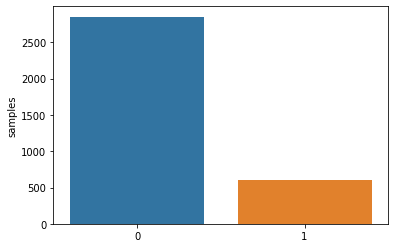

In [9]:
x=train_df.sarcasm_label.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

In [10]:
print('Shape of df train',train_df.shape)

Shape of df train (3462, 2)


In [11]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

from nlpaug.util import Action

#aug = naw.ContextualWordEmbsAug(
#    model_path='bert-base-uncased', action="insert")

aug_w2v = naw.WordEmbsAug(
    model_type='glove', model_path='/content/glove.6B.100d.txt',
    action="substitute")


In [12]:
text = train_df.iloc[0]['tweet_text']
text

'good morning , please go and vote !  it only takes  minutes and a low turnout will hand victory to the brexit party   e uelections 2019  '

In [13]:
aug_w2v.aug_p=0.01
print("Augmented Text:")
for ii in range(3):
    augmented_text = aug_w2v.augment(text)
    print(augmented_text)

Augmented Text:
good morning, please go and vote! it just takes minutes and a low turnout will hand victory to the brexit party e uelections 2019
good morning, please go and vote! it only one minutes and a low turnout will hand victory to the brexit party e uelections 2019
good morning, please go and vote! it only takes minutes and a low turnout will hand victory help the brexit party e uelections 2019


In [14]:
#train,valid=train_test_split(train_df,test_size=0.15)
#print('Shape of train',train.shape)
#print("Shape of Validation ",valid.shape)

In [15]:
from sklearn.utils import shuffle

def augment_text(df,samples,pr=0.2):
    aug_w2v.aug_p=pr
    new_text=[]
    
    ##dropping samples from validation
    df_n=df[df.sarcasm_label==1].reset_index(drop=True)

    ## data augmentation loop
    for i in tqdm(np.random.randint(0,len(df_n),samples)):
        
            text = df_n.iloc[i]['tweet_text']
            augmented_text = aug_w2v.augment(text)
            new_text.append(augmented_text)
    
    
    ## dataframe
    new=pd.DataFrame({'tweet_text':new_text,'sarcasm_label':1})
    df=shuffle(df.append(new).reset_index(drop=True))
    return df

In [16]:
sample_value = int((609*18)/100)
sample_value
train_df = augment_text(train_df,samples=sample_value)   ## change samples to 0 for no augmentation
#train_df = train.append(valid).reset_index(drop=True)


100%|██████████| 109/109 [00:13<00:00,  7.97it/s]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

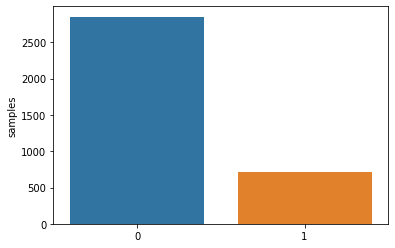

In [17]:
x=train_df.sarcasm_label.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

In [18]:
train_df.to_csv(r'/content/augmentedtrain.csv', index = False)

In [19]:
train_args = {
    'reprocess_input_data': True,
    'overwrite_output_dir': True,
    'sliding_window': False,
    'max_seq_length': 40,
    'learning_rate': 0.00001,
    'weight_decay': 0.01,
    'warmup_ratio': 0.2,
    'max_grad_norm': 1.0,
    'num_train_epochs': 13,
    'train_batch_size': 16, 
    'save_model_every_epoch': False,
    'fp16': True,
    'manual_seed': 128,
    'output_dir': '/outputs/',
    'evaluate_during_training': True,
}

In [20]:
from simpletransformers.classification import ClassificationModel
import pandas as pd
import logging
import sklearn

logging.basicConfig(level=logging.DEBUG)
transformers_logger = logging.getLogger('transformers')
transformers_logger.setLevel(logging.WARNING)

# We use the RoBERTa base pre-trained model.
model = ClassificationModel('roberta', 'roberta-base', num_labels=2, args=train_args) 

# Train the model, use the validation set as the development set as per the paper.
# When training to 1 epoch this is not that essential, however, if you decide to 
# train more and configure early stopping, do check out the simple transformers
# documentation: https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
model.train_model(train_df, eval_df=validate_df)
result, model_outputs, wrong_predictions = model.eval_model(validate_df, acc=sklearn.metrics.accuracy_score)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 139747669984656 on /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock
INFO:filelock:Lock 139747669984656 acquired on /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /roberta-base/resolve/main/config.json HTTP/1.1" 200 481


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139747669984656 on /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock
INFO:filelock:Lock 139747669984656 released on /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /roberta-base/resolve/main/pytorch_model.bin HTTP/1.1" 302 0
DEBUG:filelock:Attempting to acquire lock 139747661285648 on /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7.lock
INFO:filelock:Lock 139747661285648 acquired on /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa95

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139747661285648 on /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7.lock
INFO:filelock:Lock 139747661285648 released on /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7.lock
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you a

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139747668659792 on /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab.lock
INFO:filelock:Lock 139747668659792 released on /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab.lock
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /roberta-base/resolve/main/merges.txt HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 139747665941904 on /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock
INFO:filelock:Lock 139747665941904 acquired on /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139747665941904 on /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock
INFO:filelock:Lock 139747665941904 released on /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /roberta-base/resolve/main/tokenizer.json HTTP/1.1" 200 0
DEBUG:filelock:Attempting to acquire lock 139747665942992 on /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730.lock
INFO:filelock:Lock 139747665942992 acquired on /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd407

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139747665942992 on /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730.lock
INFO:filelock:Lock 139747665942992 released on /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730.lock
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /roberta-base/resolve/main/added_tokens.json HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /roberta-base/resolve/main/special_tokens_map.json HTTP/1.1" 404 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingf

  0%|          | 0/3571 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_40_2_2


Epoch:   0%|          | 0/13 [00:00<?, ?it/s]

Running Epoch 0 of 13:   0%|          | 0/224 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:942: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  model.parameters(), args.max_grad_norm
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/886 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_40_2_2
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Running Epoch 1 of 13:   0%|          | 0/224 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/886 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_40_2_2


Running Epoch 2 of 13:   0%|          | 0/224 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/886 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_40_2_2


Running Epoch 3 of 13:   0%|          | 0/224 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/886 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_40_2_2


Running Epoch 4 of 13:   0%|          | 0/224 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/886 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_40_2_2


Running Epoch 5 of 13:   0%|          | 0/224 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/886 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_40_2_2


Running Epoch 6 of 13:   0%|          | 0/224 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/886 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_40_2_2


Running Epoch 7 of 13:   0%|          | 0/224 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/886 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_40_2_2


Running Epoch 8 of 13:   0%|          | 0/224 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/886 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_40_2_2
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/886 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_40_2_2


Running Epoch 9 of 13:   0%|          | 0/224 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/886 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_40_2_2


Running Epoch 10 of 13:   0%|          | 0/224 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/886 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_40_2_2


Running Epoch 11 of 13:   0%|          | 0/224 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/886 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_40_2_2


Running Epoch 12 of 13:   0%|          | 0/224 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/886 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_40_2_2
INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to /outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/886 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_40_2_2


Running Evaluation:   0%|          | 0/111 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.3084340262648946, 'tp': 54, 'tn': 673, 'fp': 57, 'fn': 102, 'auroc': 0.7351949420442572, 'auprc': 0.4518286912638465, 'eval_loss': 1.2729159855359309, 'acc': 0.8205417607223476}


In [21]:
#f1-score
result, model_outputs, wrong_predictions = model.eval_model(validate_df, f1score=sklearn.metrics.f1_score)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/886 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_40_2_2


Running Evaluation:   0%|          | 0/111 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.3084340262648946, 'tp': 54, 'tn': 673, 'fp': 57, 'fn': 102, 'auroc': 0.7351949420442572, 'auprc': 0.4518286912638465, 'eval_loss': 1.2729159855359309, 'acc': 0.8205417607223476, 'f1score': 0.4044943820224719}


In [22]:
#mcc
result, model_outputs, wrong_predictions = model.eval_model(validate_df, mcc=sklearn.metrics.matthews_corrcoef)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/886 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_40_2_2


Running Evaluation:   0%|          | 0/111 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.3084340262648946, 'tp': 54, 'tn': 673, 'fp': 57, 'fn': 102, 'auroc': 0.7351949420442572, 'auprc': 0.4518286912638465, 'eval_loss': 1.2729159855359309, 'acc': 0.8205417607223476, 'f1score': 0.4044943820224719}


In [23]:
#precision
result, model_outputs, wrong_predictions = model.eval_model(validate_df, precision=sklearn.metrics.precision_score)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/886 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_40_2_2


Running Evaluation:   0%|          | 0/111 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.3084340262648946, 'tp': 54, 'tn': 673, 'fp': 57, 'fn': 102, 'auroc': 0.7351949420442572, 'auprc': 0.4518286912638465, 'eval_loss': 1.2729159855359309, 'acc': 0.8205417607223476, 'f1score': 0.4044943820224719, 'precision': 0.4864864864864865}


In [24]:
#recall
result, model_outputs, wrong_predictions = model.eval_model(validate_df, recall=sklearn.metrics.recall_score)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1402: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/886 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_40_2_2


Running Evaluation:   0%|          | 0/111 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.3084340262648946, 'tp': 54, 'tn': 673, 'fp': 57, 'fn': 102, 'auroc': 0.7351949420442572, 'auprc': 0.4518286912638465, 'eval_loss': 1.2729159855359309, 'acc': 0.8205417607223476, 'f1score': 0.4044943820224719, 'precision': 0.4864864864864865, 'recall': 0.34615384615384615}
